In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [2]:
import pandas as pd
import os
import pymc3 as pm
import arviz as az
from theano import tensor as T
from sklearn.metrics import mean_squared_error
import numpy as np
from my_utils import modeler
import importlib
importlib.reload(modeler)

<module 'my_utils.modeler' from '/workspaces/Thesis/Gaze_4_behavioural_biometrics/my_utils/modeler.py'>

In [3]:
AGGREGATED_PATH = "output/aggregated_features/"

## __Free viewing__

### __General empathy__

#### __Fixations__

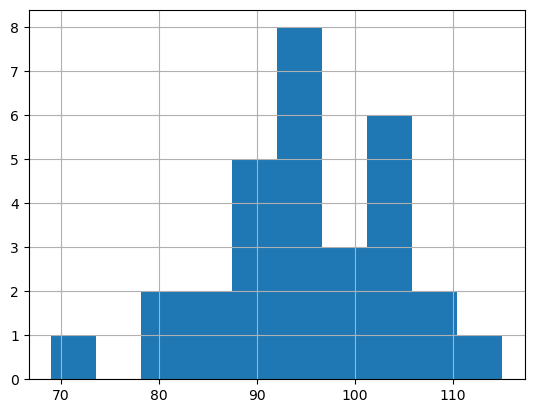

In [4]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist();

In [5]:
free_fix_features_train, free_fix_labels_train, free_sac_features_train, free_sac_labels_train =  modeler.get_features(AGGREGATED_PATH, "train", "free")

In [ ]:
n_components = 2

with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    y = pm.Data("y", free_fix_labels_train)

    a1 = pm.Normal("a1", mu=90, sigma=10)
    b1 = pm.Normal("b1", mu=0, sigma=10, shape = X.eval().shape[1])
    σ1 = pm.HalfNormal("σ1", sigma=1, shape = X.eval().shape[0])
    μ1 = pm.Normal("μ1", mu = a1 + T.dot(X, b1.T), sigma=σ1, shape = X.eval().shape[0])

    a2 = pm.Normal("a2", mu=105, sigma=10)
    b2 = pm.Normal("b2", mu=0, sigma=10, shape = X.eval().shape[1])
    σ2 = pm.HalfNormal("σ2", sigma=1, shape = X.eval().shape[0])
    μ2 = pm.Normal("μ2", mu = a1 + T.dot(X, b1.T), sigma=σ2, shape = X.eval().shape[0])

 
    μ = T.stack([μ1, μ2]).T
    σ = T.stack([σ1, σ2]).T
    
    weights = pm.Dirichlet("w", np.ones((X.eval().shape[0],n_components)), shape = (X.eval().shape[0],n_components))

    likelihood = pm.NormalMixture('likelihood', weights, μ,  σ, observed=y, shape=X.eval().shape[0])

    free_fix_empathy_trace = pm.sample(4000, tune=2000)


In [ ]:
pm.model_graph.model_to_graphviz(free_fix_empathy)

In [ ]:
az.summary(free_fix_empathy_trace, round_to=2)

In [ ]:
trace = az.plot_trace(free_fix_empathy_trace)

In [ ]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

In [ ]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)
    fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
    
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [ ]:
az.plot_ppc(fix_free_ppc_data);

In [ ]:
mean_squared_error(free_fix_labels_train, fix_free_sampled_labels, squared= False)

8.002481656193247